In [1]:
import findspark 
import pyspark
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
from pyspark.sql.functions import max , min , mean 
import pyspark.sql.functions as func 
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
findspark.init()


In [2]:
df = spark.read.csv("nuclear_plants_small_dataset.csv", inferSchema=True , header = True )
# df.where(df.Status == "Abnormal").show(10, truncate = 20)
# df.sort_values("Power_range_sensor_1")
# df.printSchema()

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [196]:
indexer = StringIndexer(inputCol="Status", outputCol="Status_index").fit(df)
df_ind = indexer.transform(df)
df_ind.select("Status_index").show(1)

+------------+
|Status_index|
+------------+
|         1.0|
+------------+
only showing top 1 row



In [23]:
# df_ind.select("Status_index","Status").show()

In [28]:
from pyspark.ml.feature import VectorAssembler 

In [31]:
df_ind.columns

['Status',
 'Power_range_sensor_1',
 'Power_range_sensor_2',
 'Power_range_sensor_3 ',
 'Power_range_sensor_4',
 'Pressure _sensor_1',
 'Pressure _sensor_2',
 'Pressure _sensor_3',
 'Pressure _sensor_4',
 'Vibration_sensor_1',
 'Vibration_sensor_2',
 'Vibration_sensor_3',
 'Vibration_sensor_4',
 'Status_index']

In [36]:
assembler = VectorAssembler(inputCols = ['Power_range_sensor_1','Power_range_sensor_2','Power_range_sensor_3 ','Power_range_sensor_4','Pressure _sensor_1','Pressure _sensor_2','Pressure _sensor_3','Pressure _sensor_4','Vibration_sensor_1','Vibration_sensor_2','Vibration_sensor_3','Vibration_sensor_4'],outputCol="features")


In [38]:
assembler

VectorAssembler_aab0272c5748

In [218]:
assembler

VectorAssembler_aab0272c5748

In [197]:
output = assembler.transform(df_ind)
output.select("features","status_index").show(5,truncate =100)

+----------------------------------------------------------------------------------------+------------+
|                                                                                features|status_index|
+----------------------------------------------------------------------------------------+------------+
|   [4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186]|         1.0|
|[4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483]|         1.0|
|  [4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408]|         1.0|
|   [5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157]|         1.0|
|  [5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966]|         1.0|
+----------------------------------------------------------------------------------------+------------+
only showing top 5 rows



In [51]:
output.select("features","Status_index").show(5,truncate=90)

+----------------------------------------------------------------------------------------+------------+
|                                                                                features|Status_index|
+----------------------------------------------------------------------------------------+------------+
|   [4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186]|         1.0|
|[4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483]|         1.0|
|  [4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408]|         1.0|
|   [5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157]|         1.0|
|  [5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966]|         1.0|
+----------------------------------------------------------------------------------------+------------+
only showing top 5 rows



In [53]:
model_df = output.select("features","Status_index")

In [219]:
model_df.show()

+--------------------+------------+
|            features|Status_index|
+--------------------+------------+
|[4.5044,0.7443,6....|         1.0|
|[4.4284,0.9073,5....|         1.0|
|[4.5291,1.0199,6....|         1.0|
|[5.1727,1.0007,7....|         1.0|
|[5.2258,0.6125,7....|         1.0|
|[4.8834,0.5786,5....|         1.0|
|[5.7422,0.8862,5....|         1.0|
|[6.5076,0.5438,7....|         1.0|
|[5.625,0.0403,7.7...|         1.0|
|[4.9942,0.4092,6....|         1.0|
|[5.9079,0.9229,5....|         1.0|
|[6.4215,0.5978,5....|         1.0|
|[5.9253,0.2161,6....|         1.0|
|[5.5783,0.6262,6....|         1.0|
|[5.495,0.4971,5.2...|         1.0|
|[5.6332,0.5182,4....|         1.0|
|[5.8438,1.1902,5....|         1.0|
|[5.4053,1.8027,5....|         1.0|
|[5.2075,1.4804,5....|         1.0|
|[6.0489,0.9576,5....|         1.0|
+--------------------+------------+
only showing top 20 rows



In [58]:
#decision tree  
training_ds , testing_ds = model_df.randomSplit([0.7,0.3])


In [61]:
training_ds.count()

700

In [63]:
testing_ds.count()

296

In [64]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [201]:
classifier_ds = DecisionTreeClassifier(labelCol= "Status_index").fit(training_ds)

In [221]:
predictions_ds = classifier_ds.transform(testing_ds)


In [210]:
predictions_ds.show(1,truncate = 10)
# "Status_index","prediction"

+----------+------------+-------------+-----------+----------+
|  features|Status_index|rawPrediction|probability|prediction|
+----------+------------+-------------+-----------+----------+
|[0.1083...|         0.0|   [60.0,2...| [0.7317...|       0.0|
+----------+------------+-------------+-----------+----------+
only showing top 1 row



In [80]:
accuracy_ds = MulticlassClassificationEvaluator(labelCol = "Status_index" , metricName = "accuracy").evaluate(predictions_ds)

In [92]:
accuracy_percentage = accuracy_ds * 100
print(accuracy_percentage,"%")


78.04054054054053 %


In [84]:
precision_ds = MulticlassClassificationEvaluator(labelCol = "Status_index" , metricName = "weightedPrecision").evaluate(predictions_ds)

In [93]:
precision_percentage = precision_ds * 100
print(precision_percentage,"%")

79.05110010322598 %


In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [117]:
dataset = pd.read_csv('Position_Salaries.csv')
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

In [132]:

y = y.reshape(len(y),1)
print(y)


[[-0.72004253]
 [-0.70243757]
 [-0.66722767]
 [-0.59680786]
 [-0.49117815]
 [-0.35033854]
 [-0.17428902]
 [ 0.17781001]
 [ 0.88200808]
 [ 2.64250325]]


In [122]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [130]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y.ravel())

SVR()

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [163]:
dataset = pd.read_csv('copy.csv')

In [193]:
dataset.shape

(996, 14)

In [211]:
X = dataset.iloc[:, [1, 2]].values
y = dataset.iloc[:, -1].values


In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [213]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [214]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [215]:
y_pred = classifier.predict(X_test)

In [216]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[83 44]
 [43 79]]


0.6506024096385542

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


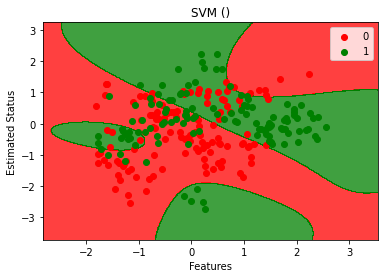

In [170]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM ()')
plt.xlabel('Features')
plt.ylabel('Estimated Status')
plt.legend()
plt.show()